Perform Hierarchical Drift-Diffusion Modeling of the StateSwitch Dynamic Responses using the HDDM toolbox

In [1]:
import hddm
print("HDDM version: "+ hddm.__version__)

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version: "+ np.__version__) 

import scipy.io as io

import warnings
warnings.filterwarnings('ignore')
print("Important: Warnings disabled for improved clarity")

import pickle

def savePatch(self, fname):
    with open(fname, 'wb') as f:
        pickle.dump(self, f)

import os
dirname = os.path.realpath('../..')


/Users/julian.kosciessa/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HDDM version: 0.9.8
Numpy version: 1.21.6
Important: Warnings disabled for improved clarity


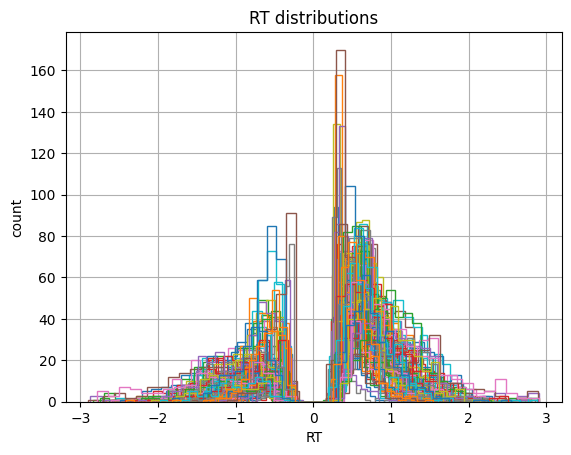

In [2]:
# get data from numpy structured array

dataPath = os.path.join(dirname, 'data')
csvData = os.path.join(dataPath,'StateSwitchDynamicTrialData.dat')
savePath = os.path.join(dataPath, 'hddm_all_sv')
if not os.path.exists(savePath):
    os.makedirs(savePath)

########################
## Load and flip data ##
########################

data = hddm.load_csv(csvData)
data.rename(columns={'acc':'response'}, inplace=True)
data.rename(columns={'subject':'subj_idx'}, inplace=True)

dataFlipped = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in dataFlipped.groupby('subj_idx'):
    subj_data.rt.hist(bins=40, histtype='step', ax=ax)
    

In [3]:
model = hddm.HDDM(data, bias=False, include=('v', 'a' ,'t'), depends_on={'v': ['dim', 'age', 'att'], 'a': ['dim', 'age', 'att'], 't': ['dim', 'age', 'att'], 'sv': ['dim', 'age', 'att']}, p_outlier=.05)
model.find_starting_values()
model.sample(7000, burn=5000, dbname=os.path.join(savePath,'traces.db'), db='pickle')
fileName = 'model'
print('Model will be saved at: '+ os.path.join(savePath,fileName))
model.savePatch = savePatch(model, os.path.join(savePath,fileName))

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 7001 of 7000 complete in 25075.3 secModel will be saved at: /Users/julian.kosciessa/Volumes/tardis/LNDG/stateswitch/stsw_beh_task/hddm_matched/data/hddm_all/model


In [4]:
# save individual results as CSV
dataMat = model.get_traces()
fileName = 'data.csv'
print('Data will be saved at: '+ os.path.join(savePath,fileName))
dataMat.to_csv(os.path.join(savePath,fileName), sep='\t')

Data will be saved at: /Users/julian.kosciessa/Volumes/tardis/LNDG/stateswitch/stsw_beh_task/hddm_matched/data/hddm_all/data.csv


In [5]:
# extract posterior predictive check RT distributions for postHoc assessment
ppc_data = hddm.utils.post_pred_gen(model,samples=100)
fileName = 'ppc.csv'
print('Data will be saved at: '+ os.path.join(savePath,fileName))
ppc_data.to_csv(os.path.join(savePath,fileName), sep='\t')

 [-----------------100%-----------------] 1633 of 1632 complete in 313.1 secData will be saved at: /Users/julian.kosciessa/Volumes/tardis/LNDG/stateswitch/stsw_beh_task/hddm_matched/data/hddm_all/ppc.csv


In [6]:
# drift rate v
v_11,v_12,v_13,v_14 = model.nodes_db.node[['v(1)', 'v(2)', 'v(3)','v(4)']]
hddm.analyze.plot_posterior_nodes([v_11,v_12,v_13,v_14])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('YA: Posterior of drift-rate group means')

KeyError: "None of [Index(['v(1)', 'v(2)', 'v(3)', 'v(4)'], dtype='object')] are in the [index]"

In [ ]:
# threshold a:
a_11,a_12,a_13,a_14 = model.nodes_db.node[['a(1)', 'a(2)', 'a(3)','a(4)']]
hddm.analyze.plot_posterior_nodes([a_11,a_12,a_13,a_14])
plt.xlim(.8, 1.75)
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

In [ ]:
# ndt t
t_11,t_12,t_13,t_14 = model.nodes_db.node[['t(1)', 't(2)', 't(3)','t(4)']]
hddm.analyze.plot_posterior_nodes([t_11,t_12,t_13,t_14])
plt.xlim(.8, 1.75)
plt.xlabel('ndt')
plt.ylabel('Posterior probability')
plt.title('YA: Posterior of ndt group means')

In [ ]:
# posterior predictive check
#model.plot_posterior_predictive()
model.plot_posteriors()

In [ ]:
print("Drift rate changes")
print("P(1 > 2)=",(v_11.trace() > v_12.trace()).mean())
print("P(2 > 3)=",(v_12.trace() > v_13.trace()).mean())
print("P(3 > 4)=",(v_13.trace() > v_14.trace()).mean())
print("")

print("Threshold changes")
print("P(1 < 2)=",(a_11.trace() < a_12.trace()).mean())
print("P(2 < 3)=",(a_12.trace() < a_13.trace()).mean())
print("P(3 < 4)=",(a_13.trace() < a_14.trace()).mean())
print("")

print("Non-decision time changes")
print("P(1 < 2)=",(t_11.trace() < t_12.trace()).mean())
print("P(2 < 3)=",(t_12.trace() < t_13.trace()).mean())
print("P(3 < 4)=",(t_13.trace() < t_14.trace()).mean())
print("")

In [ ]:
print("Model DIC: %f" % model.dic)